In [20]:

import matplotlib.pyplot as plt # plotting
import numpy as np              # working with number arrays etc.
from netCDF4 import Dataset     # reading netcdf files
import pandas as pd  
import seaborn as sns

path_les="/Users/amrapallig/run/cvmix_analysis/les/"


In [21]:

def plume_les(w3,w2,wt,ws):
    sw=w3/(w2**(3/2))
    sigma=0.5+sw/(2*np.sqrt(4+sw**2))
    wumd=np.sqrt(w2/(sigma*(1-sigma)))
    mc=sigma*(1-sigma)*wumd
    tumd=wt/mc
    sumd=ws/mc
    
    return sigma,mc,wumd, tumd, sumd, sw
  

In [22]:
    #### Lu-Ld
def lu_ld(u2,v2,w2,wt,ws,zm,temp,salt,t):   
    
        sigma, mc,wumd, tumd, sumd,sw=plume_les(les.variables['w3'][t,:], 
                                            les.variables['w2'][t,:],les.variables['wt'][t,:],
                                            les.variables['ws'][t,:])
        g=9.81
        alphaT=2*10**(-4)
        betaS=8*10**(-4)
        tke = 0.5*(u2 + v2 + w2)
        B = -g*(-alphaT*(temp - 20.0) + betaS*(salt - 35))

        sav = [(sigma[i]+sigma[i+1])/2 for i in range(0, len(sigma)-1, 1)]
        tudav =[(tumd[i]+tumd[i+1])/2 for i in range(0, len(tumd)-1, 1)]
        Tup = temp[1:]+ (1- np.array(sav))*tudav
        Tdo = temp[1:] - np.array(sav)*tudav

        sudav =[(sumd[i]+sumd[i+1])/2 for i in range(0, len(tumd)-1, 1)]
        Sup = salt[1:]+ (1- np.array(sav))*sudav
        Sdo = salt[1:] - np.array(sav)*sudav

        Bup = -g*(-alphaT*(Tup - 15.0) + betaS*(Sup - 35.0))
        Bdo = -g*(-alphaT*(Tdo - 15.0) + betaS*(Sdo - 35.0))

        BupEdge = [(Bup[i]+Bup[i-1])/2 for i in range(1, len(Bup), 1)]
        BdoEdge =[(Bdo[i]+Bdo[i-1])/2 for i in range(1, len(Bdo), 1)]

        BupEdge.insert(0,BupEdge[1])
        BdoEdge.insert(0,BdoEdge[1])
        BupEdge.insert(len(BupEdge),BupEdge[-1])
        BdoEdge.insert(len(BdoEdge),BdoEdge[-1])

        lenup=np.zeros(len(BupEdge))
        for k in np.arange(len(BupEdge)-2):
            k=k+1
            ij=k
            sumv=0
            lenup[k]=0
            while ((sumv<=tke[k]) & (ij<len(BupEdge)) ):
                sumv = sumv + (BupEdge[k] - Bup[ij])*(zm[ij-1]-zm[ij])
                lenup[k]=lenup[k]+np.abs(zm[ij-1]-zm[ij])
                ij = ij + 1
            #print (ij,k,sumv,tke[k])     
                if (sumv>tke[k]): 
                    ij = ij - 1
                    s1 = sumv
                    z1 = zm[ij]
                    zV = zm[ij-1]
                    sumv = sumv - (BupEdge[k]  - Bup[ij])*(zm[ij-1]-zm[ij])
                    lenup[k] = lenup[k]  - np.abs(zm[ij]-zm[ij+1])
                    lenup[k]  = np.maximum(0.55,lenup[k]  + np.abs((z1-zV)/(s1 - sumv)*(tke[k] -sumv)))
                    break
    #print(lenup)            

        lendn=np.zeros(len(BdoEdge))
        for k in np.arange(len(BdoEdge)-2):
            k=k+1
            ij=k
            sumv=0
            lendn[k]=0
            while ((sumv<=tke[k]) & (ij>0) ):
                sumv = sumv - (BdoEdge[k] - Bdo[ij-1])*(zm[ij-1]-zm[ij])
                lendn[k]=lendn[k]+np.abs(zm[ij-1]-zm[ij])
                ij = ij - 1
            #print (ij,k,sumv,tke[k])     
                if (sumv>tke[k]): 
                    ij = ij + 1
                    s1 = sumv
                    z1 = zm[ij]
                    zV = zm[ij-1]
                    sumv = sumv + (BdoEdge[k]  - Bdo[ij-1])*(zm[ij-1]-zm[ij])
                    lendn[k] = lendn[k]  - np.abs(zm[ij-1]-zm[ij])
                    lendn[k]  = np.maximum(0.55,lendn[k]  + ((z1-zV)/(s1 - sumv)*(tke[k] -sumv)))
                    break
        l_ratio=lenup/lendn     
        ind=np.where(lenup==0.55)
        indd=ind[0][0]
        zi=zm[indd]
        ind=np.where(np.round(zm/zi,1)==0.4)
        ind=ind[0][0]
        lup_ldn_les=l_ratio[ind]
        return(lup_ldn_les)

In [25]:
lenup_dn_z_zi_p4={}
t=95
t1=95-12
file_names = [*[f"Cooling{x}" for x in [1, 2, 4, 16]], 
              *[f"Evap{x}" for x in [1, 4]],
              *[f"Strat{x}" for x in [1, 10, 20]],
              *[f"T1S{x}" for x in [0, 1, 3, 15]],
             ]


for fn in file_names:
    les= Dataset(path_les+f'{fn}.nc', mode='r')
    u2=np.nanmean(les.variables['u2'][t1:t,:],axis=0)
    v2=np.nanmean(les.variables['v2'][t1:t,:],axis=0)
    w3=np.nanmean(les.variables['w3'][t1:t,:],axis=0)
    w2=np.nanmean(les.variables['w2'][t1:t,:],axis=0)
    wt=np.nanmean(les.variables['wt'][t1:t,:],axis=0)
    ws=np.nanmean(les.variables['ws'][t1:t,:],axis=0)
    zm=les.variables['zm'][:]
    w4=np.nanmean(les.variables['w4'][t1:t,:],axis=0)
    temp=np.nanmean(les.variables['temp'][t1:t,:],axis=0)
    salt=np.nanmean(les.variables['salt'][t1:t,:],axis=0)
    lenup_dn_z_zi_p4[f"luld_{fn}"] = lu_ld(u2,v2,w2,wt,ws,zm,temp,salt,t)


<ipython-input-22-616923feca7c>:15: UserWarning: Warning: converting a masked element to nan.
  Tup = temp[1:]+ (1- np.array(sav))*tudav
<ipython-input-22-616923feca7c>:16: UserWarning: Warning: converting a masked element to nan.
  Tdo = temp[1:] - np.array(sav)*tudav
<ipython-input-22-616923feca7c>:19: UserWarning: Warning: converting a masked element to nan.
  Sup = salt[1:]+ (1- np.array(sav))*sudav
<ipython-input-22-616923feca7c>:20: UserWarning: Warning: converting a masked element to nan.
  Sdo = salt[1:] - np.array(sav)*sudav
<ipython-input-22-616923feca7c>:75: RuntimeWarning: invalid value encountered in true_divide
  l_ratio=lenup/lendn


(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1440x576 with 0 Axes>

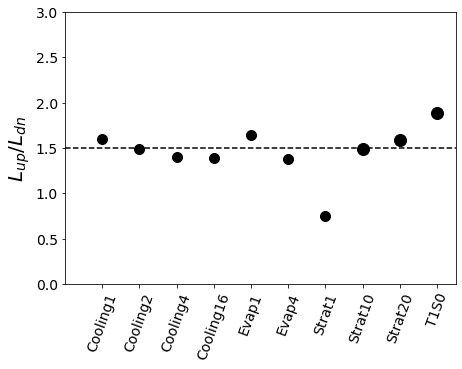

In [26]:




fig= plt.figure(figsize=(20,8))
f, ax = plt.subplots(figsize=(7,5))
d=1
plt.plot(d,lenup_dn_z_zi_p4["luld_Cooling1"],'ok',markersize=10)
d=3
plt.plot(d,lenup_dn_z_zi_p4["luld_Cooling2"],'ok',markersize=10)
d=5
plt.plot(d,lenup_dn_z_zi_p4["luld_Cooling4"],'ok',markersize=10)
d=7
plt.plot(d,lenup_dn_z_zi_p4["luld_Cooling16"],'ok',markersize=10)
d=9
plt.plot(d,lenup_dn_z_zi_p4["luld_Evap1"],'ok',markersize=10)
d=11
plt.plot(d,lenup_dn_z_zi_p4["luld_Evap4"],'ok',markersize=10)
d=13
plt.plot(d,lenup_dn_z_zi_p4["luld_Strat1"],'ok',markersize=10)
d=15
plt.plot(d,lenup_dn_z_zi_p4["luld_Strat10"],'ok',markersize=12)
d=17
plt.plot(d,lenup_dn_z_zi_p4["luld_Strat20"],'ok',markersize=12) #s10
d=19
plt.plot(d,lenup_dn_z_zi_p4["luld_T1S0"],'ok',markersize=12)  #s20
d=21
plt.plot(d,lenup_dn_z_zi_p4["luld_T1S1"],'ok',markersize=12)
d=23
plt.plot(d,lenup_dn_z_zi_p4["luld_T1S3"],'ok',markersize=12)
d=25
plt.plot(d,lenup_dn_z_zi_p4["luld_T1S15"],'ok',markersize=12) #t4w
d=27





plt.ylim(0,3)
plt.ylabel('$L_{up}/L_{dn}$',fontsize=20)
#plt.xlabel('$cases(c1,c2,c4,c16,e1,e4)$',fontsize=10)

x = ['Cooling1', 'Cooling2', 'Cooling4','Cooling16',
     'Evap1','Evap4','Strat1','Strat10','Strat20','T1S0','T1S1','T1S3','T1S15']
l = [1,3,5,7,9,11,13,15,17,19,21,23,25]
#l=l[:]+1
plt.plot([-1,20],[1.5,1.5],'--k')
ax.set_xticks(l)
ax.set_xticklabels(x,fontsize=15)
for tick in ax.get_xticklabels():
    tick.set_rotation(70)
#plt.grid(True) 
plt.xlim(-1,20)
plt.ylim(0,3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
